This notebook munges the AUC values for the Tumor vs. Normal prediction task and makes several visualizations.

In [1]:
import getpass
import sys
import time

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
mpl.rcParams['figure.dpi'] = 200

In [4]:
print(getpass.getuser())

cthoyt


In [5]:
print(sys.version)

3.7.3 (default, Mar 27 2019, 09:23:39) 
[Clang 10.0.0 (clang-1000.11.45.5)]


In [6]:
print(time.asctime())

Thu May  9 16:08:29 2019


In [7]:
df = pd.read_csv('../../input/tumor_prediction_results.tsv', sep='\t')
df = df.sort_values(['Database', 'Dataset'])
df.head()

,Database,Dataset,AUC
40,KEGG,BRCA,0.990240
41,KEGG,BRCA,0.993994
42,KEGG,BRCA,1.000000
43,KEGG,BRCA,1.000000
44,KEGG,BRCA,0.995041


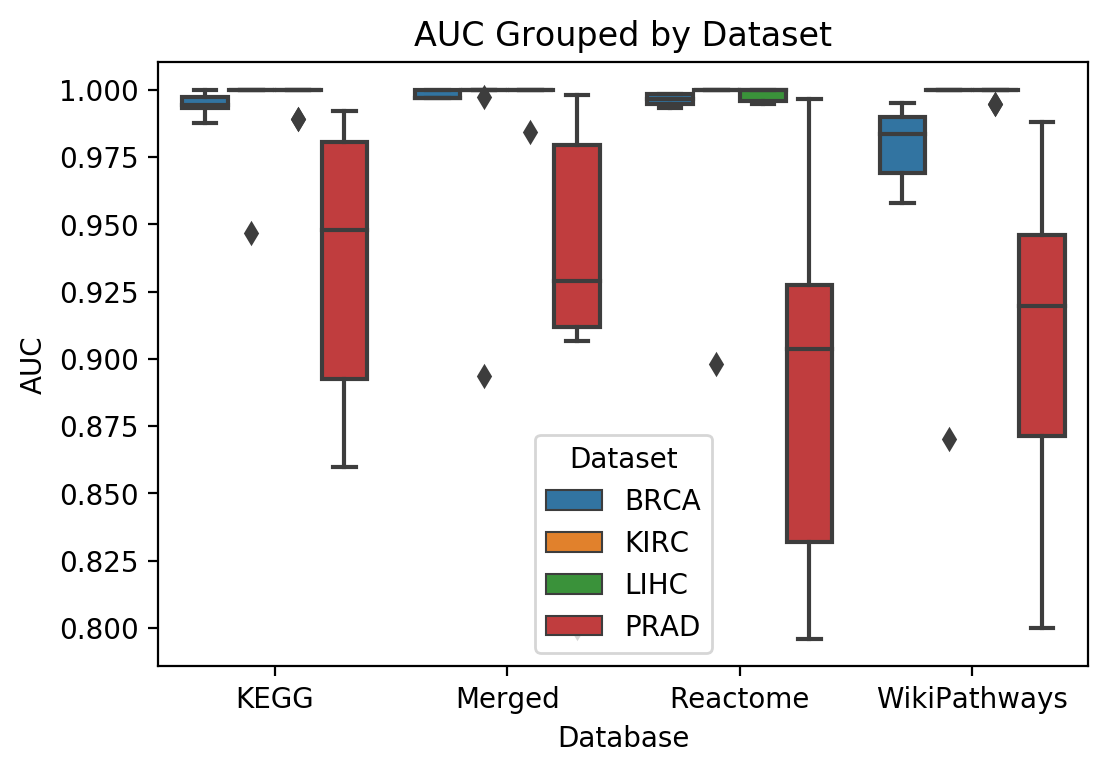

In [8]:
sns.boxplot(
    y='AUC',
    x='Database',
    hue='Dataset',
    data=df
)
plt.title('AUC Grouped by Dataset')
plt.show()

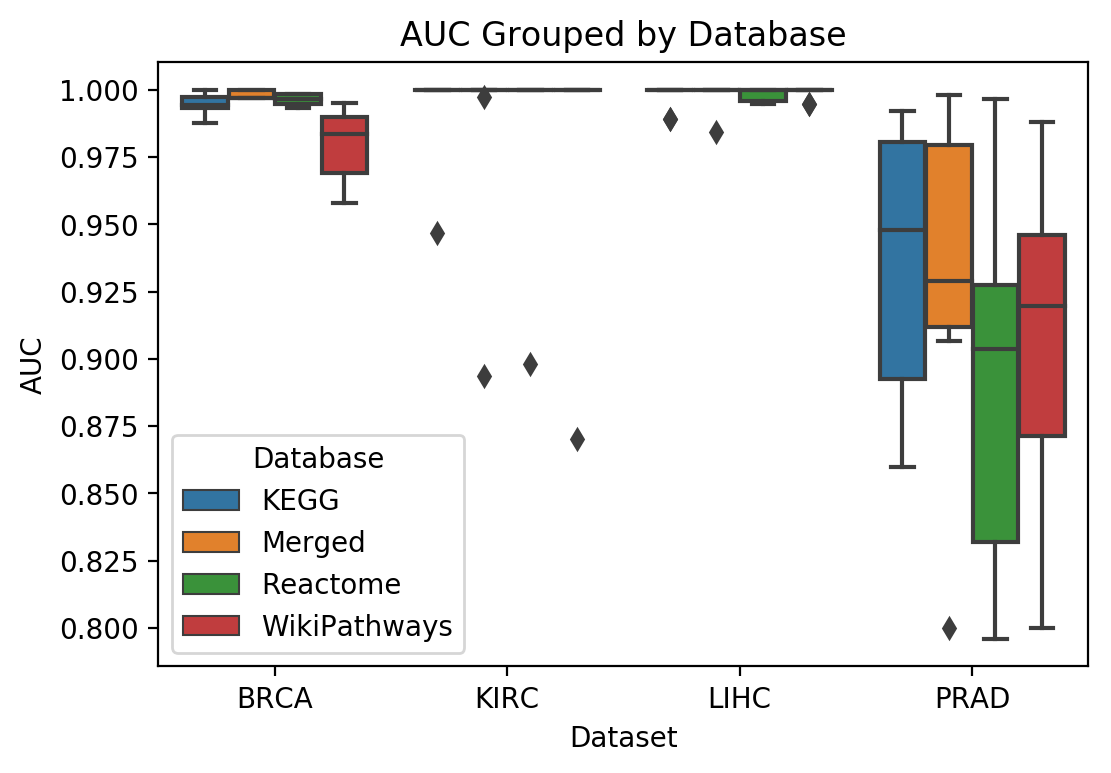

In [9]:
sns.boxplot(
    y='AUC',
    x='Dataset',
    hue='Database',
    data=df
)
plt.title('AUC Grouped by Database')
plt.show()

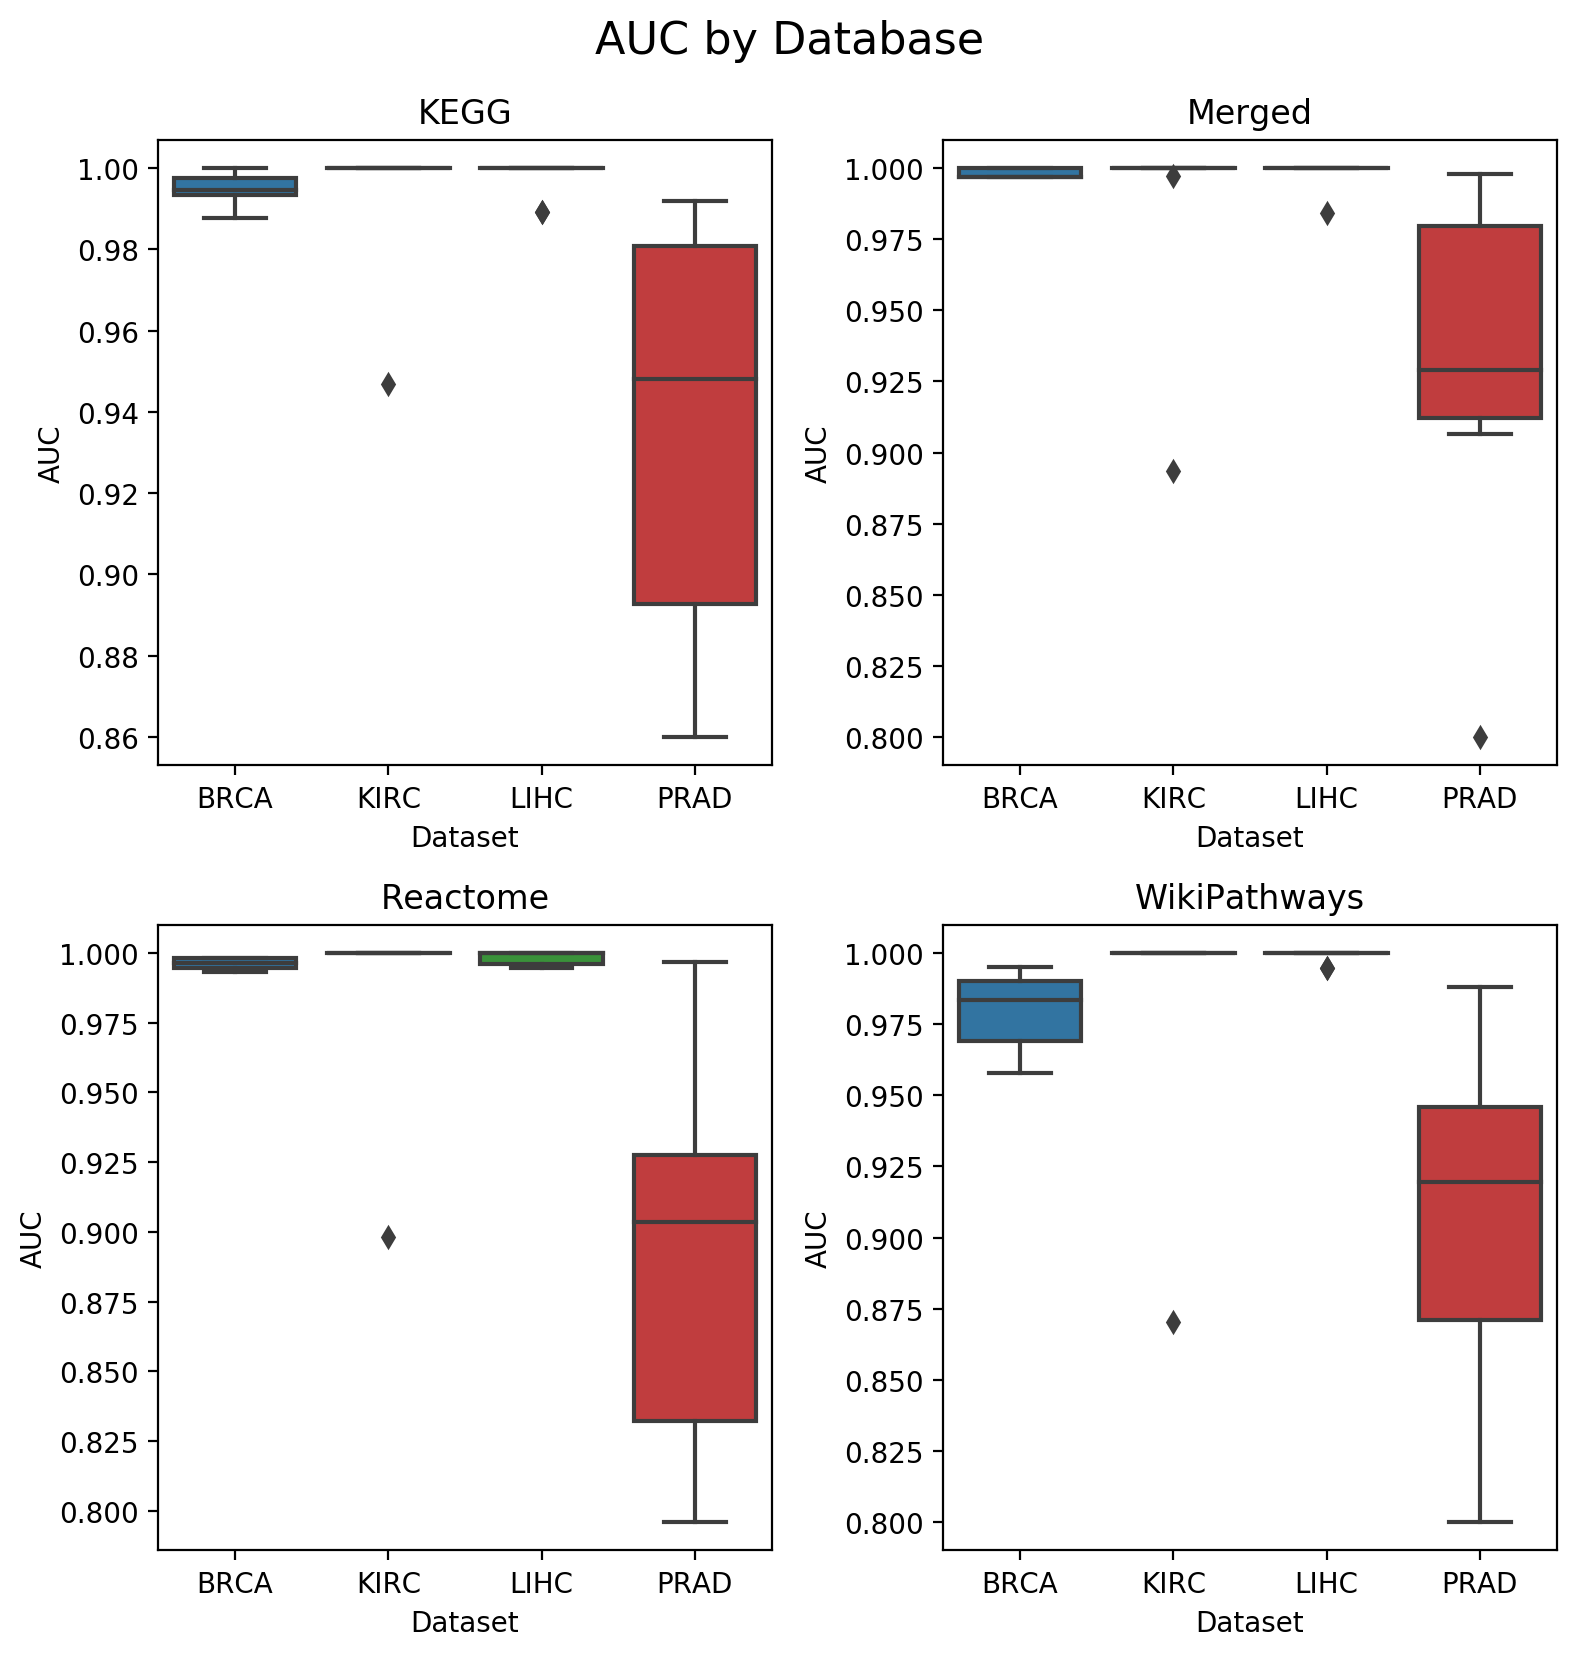

In [10]:
ncols = 2
nrows = df['Database'].nunique() // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 8))

plt.suptitle('AUC by Database', fontsize=16, y=1.03)

y_min = df['AUC'].min()

for database, ax in zip(df['Database'].unique(), axes.ravel()):
    ax.set_title(database)
    # Use this to make the y-axes all use the same, but makes readability difficult
    # ax.set_ylim(bottom=y_min, top=1.0)  
    sns.boxplot(
        y='AUC',
        x='Dataset',
        data=df[df['Database'] == database],
        ax=ax,
    )

plt.tight_layout()
plt.show()

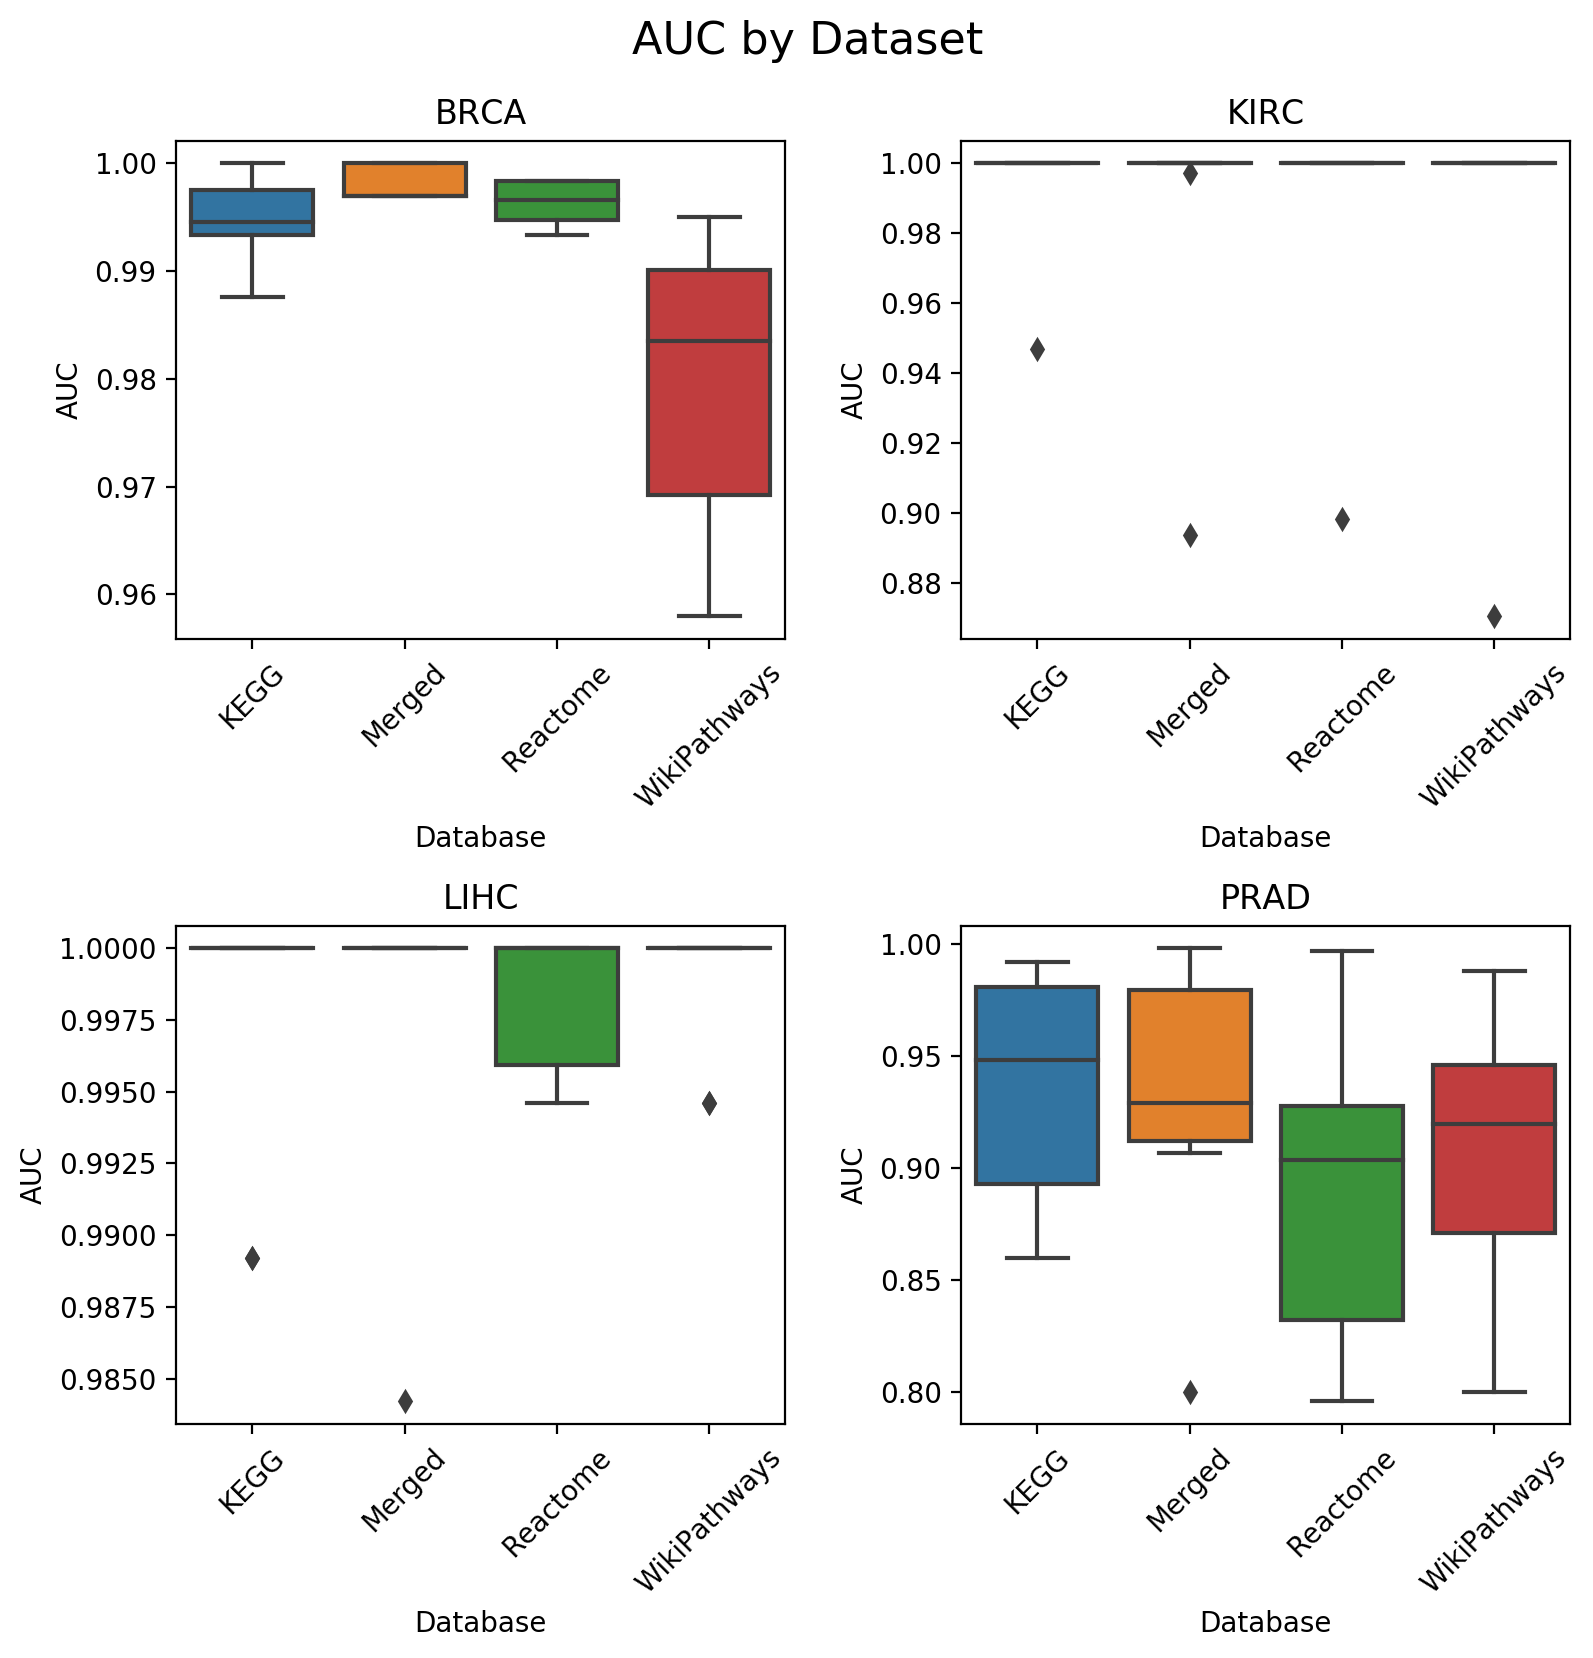

In [11]:
ncols = 2
nrows = df['Dataset'].nunique() // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 8))

plt.suptitle('AUC by Dataset', fontsize=16, y=1.03)

for dataset, ax in zip(df['Dataset'].unique(), axes.ravel()):
    ax.set_title(dataset)
    # Use this to make the y-axes all use the same, but makes readability difficult
    # ax.set_ylim(bottom=y_min, top=1.0)  
    sns.boxplot(
        y='AUC',
        x='Database',
        data=df[df['Dataset'] == dataset],
        ax=ax,
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()